# FAIR Data use case: Geospatial data

## Overview

In this episode, we explore how the concrete aspects of the FAIR data principles that have been discussed in the lesson apply in the context of a typical workflow that involves geospatial data, using a satellite imagery dataset as an example study case. 

## What is geospatial data?

Geospatial data is data which provides information about a location on the Earth's surface and typically associated with a precise time of observation.  A common type of geospatial data in the field of climate and geo-science is raster data, i.e. data that can be represented as a grid of cells ("pixels") whose row and column indices are associated to geographic coordinate values. Raster data is the data type that best fits remote sensor's products like satellite imagery, in essence snapshots of the Earth's surface.

## Why FAIR?

Advances in sensors, storage and computing infrastructures make it possible for space agencies and private data providers to offer researchers massive and continuously growing data catalogs, with huge potential for scientific discoveries. The implementation of the FAIR principles for these datasets is essential in order to enable data usability and research reproducibility. In particular, important aspects involve:
* offering programmatic access to the data;
* sharing rich and machine-readable metadata; 
* making use of standards-compliant formats.

As a use case, we focus on the Sentinel-2 data collection that is openly available [in a public S3 bucket on Amazon Web Services (AWS)](https://registry.opendata.aws/sentinel-2-l2a-cogs/). This dataset consists of multi-band optical images acquired by the two satellites of the [Sentinel-2 mission](https://sentinel.esa.int/web/sentinel/missions/sentinel-2), continuously updated with new images.

## Access to the data

Datasets such as the one discussed above cannot be made accessible to users via a full-catalog download. Manually browsing and looping through files is a nice way to explore a dataset, but it represents a heavy and error-prone task that should be avoided if carried out systematically to retrieve data. A service that offers programmatic access to the data enables users to reach the desired data in a more reliable, scalable and reproducible manner. 

The use of standards in the software interface exposed to the users (generally called the application programming interface, API) is important, since it can significantly facilitate the reusability of tools and scripts across datasets and applications.

The AWS Sentinel-2 collection is accessible through an [API](https://earth-search.aws.element84.com/v0/api), which can be used to query the full catalog for the scenes matching a provided set of parameters. Both the catalog and the dataset are publicly accessible, so they can be reached without authentication. The catalog can also be browsed [at this link](https://stacindex.org/catalogs/earth-search#/?t=catalogs). The catalog follows the SpatioTemporal Asset Catalog (STAC) specification, an emerging standard for describing geospatial data, thus making it possible to access data from different collections and data providers with the same set of tools. 

As an example, we can query the Sentinel-2 collection, identified by the following ID:

In [1]:
collection_id = "sentinel-s2-l2a-cogs"

with the [`pystac-client` tool](https://github.com/stac-utils/pystac-client) in order to find the available scene(s) for the specified set of parameters:

In [2]:
coords = dict(type="Point", coordinates=(4.9041, 52.3676)) # lon, lat of Amsterdam
time_range = "2021-02-08/2021-02-14"  # week after the Darcy snow storm
query = "eo:cloud_cover<30" # filter elements with low cloud cover (less than 30%)

In [3]:
from pystac_client import Client

url = "https://earth-search.aws.element84.com/v0" # URL to the STAC API on AWS
catalog = Client.open(url)

mysearch = catalog.search(
    collections=[collection_id],
    intersects=coords,
    datetime=time_range,
    query=[query]
)

print(mysearch.matched())  # one item match the search!

1


We can then open the item using [Intake](https://intake.readthedocs.io), which is a library for data access and dissemination, interfaced to STAC via a [dedicated plugin](https://intake-stac.readthedocs.io/en/latest/):

In [4]:
import intake_stac
intake_stac.catalog.drivers['application/xml'] = 'textfiles'
import intake

items = mysearch.items()  # open items as generator
item_url = next(items).get_self_href()
item = intake.open_stac_item(item_url)

An item in a STAC catalog can be linked to multiple files ("assets"). For instance, the Sentinel-2 products are  provided as multiple raster files (one per optical band aquired by the multi-spectral instrument), with additional files including a thumbnail, a true-color image ("visual"), instrument metadata and scene-classification information ("SCL"):

In [5]:
list(item)

['thumbnail',
 'overview',
 'info',
 'metadata',
 'visual',
 'B01',
 'B02',
 'B03',
 'B04',
 'B05',
 'B06',
 'B07',
 'B08',
 'B8A',
 'B09',
 'B11',
 'B12',
 'AOT',
 'WVP',
 'SCL']

## Metadata

Metadata is an essential aspect of geospatial data. On the one hand, descriptive metadata is used to make the data findable and accessible, by providing e.g. information such as the geographic location or the time of the observation alongside the data. On the other hand, instrument and measurement metadata, i.e. the parameters that characterize the state of the sensor and of the environment at the time of the observation, can be as important as the data in order to make sense of it.  

In the Sentinel-2 collection that we focus on, metadata is available at various levels. At the highest level, metadata is provided in the STAC item itself, and accessible via Intake with the `metadata` attribute:

In [6]:
item.metadata

{'datetime': datetime.datetime(2021, 2, 11, 10, 46, 24, tzinfo=tzutc()),
 'platform': 'sentinel-2a',
 'constellation': 'sentinel-2',
 'instruments': ['msi'],
 'gsd': 10,
 'view:off_nadir': 0,
 'proj:epsg': 32631,
 'sentinel:utm_zone': 31,
 'sentinel:latitude_band': 'U',
 'sentinel:grid_square': 'FU',
 'sentinel:sequence': '0',
 'sentinel:product_id': 'S2A_MSIL2A_20210211T104151_N0214_R008_T31UFU_20210211T133331',
 'sentinel:data_coverage': 67.73,
 'eo:cloud_cover': 0.02,
 'sentinel:valid_cloud_cover': True,
 'created': '2021-02-11T18:36:36.435Z',
 'updated': '2021-02-11T18:36:36.435Z',
 'bbox': [4.795671444512658,
  52.22257539160586,
  6.1417542968794585,
  53.22891416854278],
 'geometry': {'type': 'Polygon',
  'coordinates': [[[6.071664488869862, 52.22257539160586],
    [4.795671444512658, 52.24889811809928],
    [5.221470460722203, 53.22891416854278],
    [6.1417542968794585, 53.20819279121764],
    [6.071664488869862, 52.22257539160586]]]},
 'date': datetime.date(2021, 2, 11)}

Metadata at this level enables the programmatic search for items, allowing users to filter items on the basis of their geo-location and time of acquisition, but also other properties such as the fraction of the scene that is covered by clouds.

Lower-level metadata consists of the measurement metadata files that accompany Sentinel-2 data products. It is provided in XML format, and it includes general information about the scene (sun and view angles), detailed geo-location information, as well as data-quality check indicators. The file is provided as an item asset (labeled 'metadata'), and can be read via Intake:

In [7]:
metadata = item['metadata'].read()
metadata[:20]  # print the first 20 lines

['<?xml version="1.0" encoding="UTF-8" standalone="no"?>\n',
 '<n1:Level-2A_Tile_ID xmlns:n1="https://psd-14.sentinel2.eo.esa.int/PSD/S2_PDI_Level-2A_Tile_Metadata.xsd" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="https://psd-14.sentinel2.eo.esa.int/PSD/S2_PDI_Level-2A_Tile_Metadata.xsd /gpfs/dpc/app/s2ipf/FORMAT_METADATA_TILE_L1C/02.14.00/scripts/../../../schemas/02.17.00/PSD/S2_PDI_Level-2A_Tile_Metadata.xsd">\n',
 '  <n1:General_Info>\n',
 '    <L1C_TILE_ID metadataLevel="Brief">S2A_OPER_MSI_L1C_TL_VGS2_20210211T125423_A029463_T31UFU_N02.09</L1C_TILE_ID>\n',
 '    <TILE_ID metadataLevel="Brief">S2A_OPER_MSI_L2A_TL_VGS2_20210211T133331_A029463_T31UFU_N02.14</TILE_ID>\n',
 '    <DATASTRIP_ID metadataLevel="Standard">S2A_OPER_MSI_L2A_DS_VGS2_20210211T133331_S20210211T104437_N02.14</DATASTRIP_ID>\n',
 '    <DOWNLINK_PRIORITY metadataLevel="Standard">NOMINAL</DOWNLINK_PRIORITY>\n',
 '    <SENSING_TIME metadataLevel="Standard">2021-02-11T10:46:24.276709Z</SENS

## File format 

The choice of a dataset file format strongly affects its interoperability: adopting open, standardized, community-established formats makes it possible for users to extract the desired pieces of information from the data. 

The choice of the format also influences many aspects of the dataset accessibility. For large geospatial datasets, it is particularly relevant that the data is organized in "tiles", so that users can access data subsets without having to load the full dataset. 

Another relevant aspect is the access protocol for which the format (and the corresponding software libraries) has been designed. Traditionally, formats for scientific datasets have been developed with a filesystem-like access in mind. Instead, datasets that are meant to be read/written via HTTP requests, like in cloud object storage environments, should make use of formats that are more suitable for this type of access (typically referred to as to "cloud-optimized" formats), since they can provide significantly better performance. 

In the Sentinel-2 collection employed in this use case, raster files are provided in [cloud-optimized GeoTIFF](https://www.cogeo.org) format. The file format employed is described in the asset's metadata, see e.g. for the true-color image that is linked to the item selected above:

In [17]:
item['visual'].metadata['type']

'image/tiff; application=geotiff; profile=cloud-optimized'

Again, we can load the raster data using Intake, which, in turn, uses Xarray and Dask to open the remote file:

In [10]:
import rioxarray

visual = item['visual'].to_dask()
visual

<xarray.DataArray (band: 3, y: 10980, x: 10980)>
dask.array<open_rasterio-b2e2afe96a6c7ab72068d488dc276125<this-array>, shape=(3, 10980, 10980), dtype=uint8, chunksize=(3, 10980, 10980), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06 5.79e+06
  * x        (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
Attributes:
    transform:           (10.0, 0.0, 600000.0, 0.0, -10.0, 5900040.0)
    crs:                 +init=epsg:32631
    res:                 (10.0, 10.0)
    is_tiled:            1
    nodatavals:          (0.0, 0.0, 0.0)
    scales:              (1.0, 1.0, 1.0)
    offsets:             (0.0, 0.0, 0.0)
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE

Note that at this stage only metadata and other geo-information have been parsed from the remote file - not the data itself. The cloud-optimized version of the GeoTIFF format is internally organized with a tiled structure, such that only a portion of the image can be accessed without the need of downloading the full GeoTIFF. For instance, we can crop a piece of the image, which has the following total spatial extent:

In [11]:
# the coordinate reference system (CRS) is EPSG:32631
visual.rio.bounds()  # min x, min y, max x, max y (in meters)

(600000.0, 5790240.0, 709800.0, 5900040.0)

in the following way:

In [12]:
visual_clip = visual.rio.clip_box(
    minx=624000, 
    miny=5800000, 
    maxx=634000, 
    maxy=5810000
)

/opt/miniconda3/envs/test/lib/python3.7/site-packages/pyproj/crs/crs.py:292: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


Only the sub-tiles overlapping with the selected portion of the image will be retrieved. The data  download is triggered only when it is required, for instance when asking for a plot of the data - the Sentinel-2 impression of snow-covered Amsterdam and surroundings:

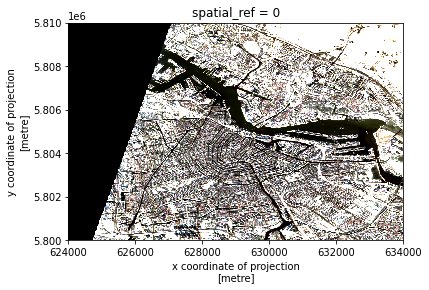

In [15]:
visual_clip.plot.imshow()